# Residual Network

Residual Networks are pretty simple actually. Sounds complex but its really not all that special, except in the results they produce. 

- Think of a normal network where you have 5 layers, A to E. 
- In a residual network, the only difference is that output of A not only goes into B, but also goes into layer C. This is called a **Skip Connection.**
- People who've done Control Systems can think of it as a feedforward loop. Funnily enough, it has a similar functionality of optimizing.
- A skip connection can also have additional layers before being added into the *'forward'* path.
- Here's a simplified diagram.

![image](img/resnet.png)

### But Why ResNets?

The idea behind ResNets is pretty much, "Hey, it doesn't hurt. So why not?" <br>
Surprisingly, this ended up being pretty big because it *helped* a lot more than it hurt.

- Residual Networks have a unique propert of being able to **"learn" the Identity Function**
- In layman terms, considering the worst case scenario, a residual connection will give you an output that's exactly the same as the input. i.e <br>**Input x Residual Network = Input**      <br>
(Identity Function I follows *A x I = A*)
- So these extra layers don't affect training error negatively, it doesn't "hurt" and this is in the absolute worst cases. At most, it just increases time and computational cost.
- In the best cases however, each layer learns something based on past and current inputs, and has the advantage of not digressing down a path that leads to very high error. 
- Normal Networks (with no skipped connections) find it harder and harder to choose and learn correctly the deeper the network gets. Simply put, more layers of a normal network leads to higher chances of error
- However, since a Residual Network continuously checks and adds the past input, the training error doesn't ever grow exponentially!

So,  let's do this!


_______
## Imports and Preprocessing

In [3]:
from DataPreprocess import bandwise_split
import matplotlib.pyplot as plt

DataPreProcess is the file with all the preprocessing and splitting into frequency bands from the previous notebook. 

In [4]:
file1 = r'C:\Users\Aditi\Documents\Machine Learning\BCI Dataset\BCICIV_3_mat\S1.mat'
file2 = r'C:\Users\Aditi\Documents\Machine Learning\BCI Dataset\BCICIV_3_mat\S2.mat'

In [13]:
X_train, X_test, Y_train, Y_test = bandwise_split(file2, split = True, train_size=0.8) 

x shape - True
y sum - True


In [14]:
print("# samples, time, channels")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# samples, time, channels
(1280, 400, 5)
(1280, 4)
(320, 400, 5)
(320, 4)


______
So we have our data ready, time to make our model.


In [1]:
from keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                          BatchNormalization, Activation, Add,
                          Flatten, Dense)
from keras.models import Model, load_model
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import (ModelCheckpoint,
                             TensorBoard, ReduceLROnPlateau,
                             CSVLogger, EarlyStopping)
from keras.backend.tensorflow_backend import set_session
from ResNet import ResidualUnit

c:\users\aditi\appdata\local\continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


The Residual unit codes are from [here](https://github.com/antonior92/automatic-ecg-diagnosis) who made an Automatic ECG analyser. They used a convolutional neural network even though its not an image, and it brought very good results. So I tried the same with this EEG dataset, and yepp, definitely gave good results.<br>
After a spectacular failed trial with RNNs, I found this usage of a residual network, and it proved fruitful!

In [9]:
kernel_size = 8
kernel_initializer = 'he_normal'
signal = Input(shape=(400, 5), dtype=np.float32, name='signal')

x = signal
x = Conv1D(32, kernel_size, padding='same', use_bias=False,
           kernel_initializer=kernel_initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x, y = ResidualUnit(200, 64, kernel_size=kernel_size,
                    kernel_initializer=kernel_initializer)([x, x])
x, y = ResidualUnit(100, 128, kernel_size=kernel_size,
                    kernel_initializer=kernel_initializer)([x, y])
x, y = ResidualUnit(50, 256, kernel_size=kernel_size,
                    kernel_initializer=kernel_initializer)([x, y])
x, y = ResidualUnit(25, 512, kernel_size=kernel_size,
                    kernel_initializer=kernel_initializer)([x, y])
x, _ = ResidualUnit(12, 512, kernel_size=5,
                    kernel_initializer=kernel_initializer)([x, y])

x = Flatten()(x)
diagn = Dense(4, activation='sigmoid', kernel_initializer=kernel_initializer)(x)
model = Model(signal, diagn)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## The Network Architecture
So here we have 5 Residual Blocks. <br>Each Residual Block has 2 Conv layers in the forward path and ne mini Conv layer in the skipped connection path. Add the Batch Norm and Pooling layers and you have well, a lot of layers. <br>

At the end of every Convolutional Net, there's always a Dense layer, or a fully connected layer. This is the actual "classifier layer" that will calculate which class the input belongs too. <br>(Maybe I should add another Dense layer? )
____

This is what the architecture of one Residual Block looks like (the dimensions correspond to the first block)
![image](img/resblock.png)

Note: **Batch Normalization (BN) - what is it?** <br>
- In general, the convention for preprocessing one's input data is to normalize the data right?
- You try to make sure all the features lie in the same range so that no one feature gets priority becuase the original values are simply higher.
- That's what Batch Norm layers do as well, but for *the Neural Network co-efficients.*
- These layers make sure that none of the weights that you are optimizing gets too large or too small , and for this, you normalize the inputs to the layers routinely throughout your network.
____

Note2: **Pooling, why?**

The "Max-Pooling Layer" is simple a maximum kernel (for all you Image Processing people, this will sound familiar) 
It takes the max of every n-neighbour cells along the horizontal and vertical axes throughout the picture. 
- Pooling layers have one functionality - **highlight the most important features.**
- You reduce the parameters after each convolution, and you choose the reduced parameters such that only the "best" or "most important" ones remain. Hence, the max function.
- I've heard average pooling is done too, but Max-pooling has worked efficiently in numerous networks before, so it has an empirical basis for being the best choice

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             (None, 400, 5)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 32)      1280        signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 32)      128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 400, 32)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_3 (

In [11]:
loss = 'binary_crossentropy'
lr = 0.001
batch_size = 64
opt = Adam(lr)
callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=7,
                               min_lr=lr / 10),
             EarlyStopping(patience=9, min_delta=0.00001)]

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


So there are some complicated additions here. <br>
- The ReduceLROnPlateau (wow tat's a mouthful) is a function that reduces the learning rate once the validation loss starts to become constant.
- This is to ensure that we don't skip the optima with larger Larning rate values that are needed at the start of training.
- EarlyStopping is to ensure that we don't skip the optimum and move back up the convex during gradient descent. 
- In simpler terms, these are to ensure that training error stays minimum and that the optimum value is reached with the best accuracy
_________

In [12]:
#To create logs
callbacks += [TensorBoard(log_dir='./logs', batch_size=batch_size, write_graph=False),
              CSVLogger('training.log', append=False)]  # Change append to true if continuing training
# Save the BEST and LAST model
callbacks += [ModelCheckpoint('./backup_model_last.hdf5'),
              ModelCheckpoint('./backup_model_best.hdf5', save_best_only=True)]


____
## Training
**Now that we have made our model and added all the required parameters, let's train!** <br> (I know I've put 200 epochs, but it rarely ever completes 200 fully because the optimum value is reached before hand, generally around 57 - 90, but this is just a safeguard)<br> (Also, a lot of tensorflow warnings come up regarding Dropout rate and stuff, just ignore them, don't worry about it)

In [13]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=200,
                    validation_split=0.05,
                    shuffle='batch',
                    callbacks=callbacks,
                    verbose=1)



Train on 1216 samples, validate on 64 samples






Epoch 1/200
1216/1216 [==============================] - 44s 36ms/step - loss: 0.9525 - acc: 0.6587 - val_loss: 0.6295 - val_acc: 0.7500

Epoch 2/200
1216/1216 [==============================] - 44s 36ms/step - loss: 0.8552 - acc: 0.6752 - val_loss: 0.6432 - val_acc: 0.7148
Epoch 3/200
1216/1216 [==============================] - 45s 37ms/step - loss: 0.7995 - acc: 0.6891 - val_loss: 0.6094 - val_acc: 0.7383
Epoch 4/200
1216/1216 [==============================] - 47s 39ms/step - loss: 0.7377 - acc: 0.6994 - val_loss: 0.5484 - val_acc: 0.7500
Epoch 5/200
1216/1216 [==============================] - 47s 39ms/step - loss: 0.7253 - acc: 0.7021 - val_loss: 0.5948 - val_acc: 0.7500
Epoch 6/200
1216/1216 [==============================] - 48s 39ms/step - loss: 0.7162 - acc: 0.7052 - val_loss: 0.6067 - val_acc: 0.7539
Epoch 7/200
1216/1216 [==============================] - 49s 40ms/step - loss: 0.6829 - acc: 0.7144 - val_loss: 0.5542 - va

## Tuning the hyperparameters
**So, I tried a lot of different variations of the parameters below.** <br>
1. The initializer, he_normal worked the best. He_uniform also works pretty decently<br>
I tried changing the number of filters in the first layer to 16 and 8, but that seemed to be counter productive and reduced the final accuracy by a lot, and introduced a lot of variance surprisingly. I thought the jump from 400x5 to 400x32 is too much, but turns out it's just right.

2. Tuning the number of layers, well, yikes it takes way too long to get the most optimized. <br> 
I started with 4 ResNet Units with different values of pooling and filters, these are optimum. Feel free to change the number of filters (32/64/128/256 to higher or lower) and test different combinations out. I plan on crating a table and seeing how much the accuracy improves or worsens and optimizing it. But my dear laptop is too slow for my impatience, so I'll get to that later (or run it on collab I guess)

3. I didn't really change the activation functions much, relu (with classifier as sigmoid) have proven in MANY, MANY projects to be the best choice.

4. Lastly, I tried tuning alpha. I wanted to reduce the learning rate when it seemed to be getting close to the global optimum. Hence the reduce LR on plateau. I tried a few different starting values, but 0.001 just seems to work really. Additionally, i tried an alpha decay, but they either decayed too fast or too slow. I'll see if I can include an exponential decay into the plateud LR and see if it helps. The sudden drop (halving of LR on plateau of val_loss) is counter-intuitive, but seems to work for many people so it can stay for now.

____________

## Results!

In [14]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

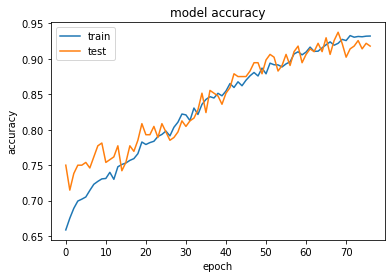

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

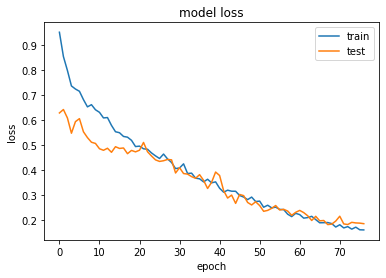

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.save("./final_model.hdf5")

In [7]:
#Use this to load previous saved model
model = load_model("./final_model.hdf5")

____
### Accuracy and related Metrics
First we have to use the model to predict results for the test data

In [15]:
y_score = model.predict(X_test, batch_size=64, verbose=1)

320/320 [==============================] - 1s 4ms/step


In [16]:
#I made this function before I realised sklearn and numpy have a relu function, sue me
def relu(a):
    b = []
    for i in a:
        ab = i==max(i)
        b.append(ab*1.0)
    return b

In [17]:
y_predict = relu(y_score)

To get an absolute accuracy, I used the following lines of code. AUC/ROC curves ended up giving me higher than the actual correct values. I may have screwed up a bit there, but this works for now.<br>
I'll update with some better metrics later


In [18]:
summ = 0
for i,j in zip(y_predict, Y_test):
    a = np.where(i==1.0)[0][0]
    b = np.where(j==1.0)[0][0]
#     print(a, b)
    summ += (a==b)*1

In [19]:
summ/320

0.95625

I still have a few ideas to make the accuracy even better, both in terms of modifing the architecture and augmenting the dataset.
That's what I'll be working on for the next few iterations of this 

_______________